# MinION based Detection Software {MINDS} 
## Developed By : Samir V. Deshpande ; samir.v.deshpande.ctr@mail.mil
## Date: 09/19/2019 @ 07:15 am

Submit the two files namely the result and report generated by Centrifuge as ResultFile and ReportFile. Change the file2 and fig1 file names in the cell number 2 under # output file section to the sample name you would like the file to be saved.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import csv

## Run centrifuge on the fastq file selected by the end user
### Implemented on 08/09/2019 @ 1520

In [2]:
%gui qt

from PyQt5.QtWidgets import QFileDialog

def gui_fname(dir=None):
    """Select a file via a dialog and return the file name."""
    if dir is None: dir ='./'
    fname = QFileDialog.getOpenFileName(None, "Select fastq file...", 
                dir, filter="All files (*);; fastq Files (*.fastq)")
    return fname[0]

In [3]:
fastq_file=gui_fname('')
print("File selected:"+fastq_file)

File selected:/home/samir/projects/MINDS/fastq/MSA_2002_MP_LWP.fastq


In [4]:
samplename_w_ext = os.path.basename(fastq_file)
samplename, file_extension = os.path.splitext(samplename_w_ext)
print(samplename)

MSA_2002_MP_LWP


In [8]:
# centrifuge database file
db_file="~/projects/MINDS/centrifuge_db/p_compressed_h_v/p_compressed+h+v"


In [9]:
# input files on macOS have differet path so be mindful of that.
# Results file has all the reads infos & has 8 coloumns
# Report file has the centrfuge report and has 7 columns
fldresults='~/projects/MINDS/centrifuge_rslts/'
Resultfile=fldresults+samplename+'_results.txt'
Reportfile=fldresults+samplename+'_report.txt'
print(Reportfile)


~/projects/MINDS/centrifuge_rslts/MSA_2002_MP_LWP_report.txt


In [10]:
%timeit
#! centrifuge -x ~/analysis/centrifuge/db/p+h+v/p+h+v -U ~/analysis/porechop/porechop_msa_2002_lee2.fastq -t -p 8 -s centrifuge_msa_2002_lee2_Results.txt --report-file centrifuge-msa_2002_lee2_Report.txt --exclude-taxids 9606 --mm 
! centrifuge -x {db_file} -q {fastq_file} -t -p 8 -S {Resultfile} --report-file {Reportfile} --exclude-taxids 9606 --mm 
#--k 1

Time loading forward index: 00:00:00
Time loading reference: 00:00:00
Multiseed full-index search: 00:08:49
Time searching: 00:08:49
report file /home/samir/projects/MINDS/centrifuge_rslts/MSA_2002_MP_LWP_report.txt
Number of iterations in EM algorithm: 0
Probability diff. (P - P_prev) in the last iteration: 0
Calculating abundance: 00:00:00
Overall time: 00:09:00


In [11]:
# files are defines here

# output files
ofile=''
file2="_MINDS_Report.csv"

fig1="_MINDS-HeatMap.png"
fig2="_MINDS-PieChart.png"
fig3="_MINDS-Histogram.png"

# dataframes are defined here
dfResult=pd.read_csv(Resultfile,sep="\t")
dfReport=pd.read_csv(Reportfile,sep="\t")

In [12]:
# Get the Sample & Path information here
from os.path import expanduser

Sample=os.path.basename(Reportfile)
Sample=os.path.splitext(Sample)[0]
S_path=os.path.dirname(Reportfile)
S_path=expanduser(S_path)
#print(S_path)
# compute the abundance
dfReport['abundance']= dfReport['numUniqueReads']*100 / dfReport['numReads']
# count the number of unclassified reasd in the dfResult
dfUnC=dfResult[dfResult.taxID ==0]
unc_reads=dfUnC.shape[0]
Unc_Results=dfResult.groupby('readID').size()
#Unc_Results.to_csv('Unique.csv',sep=',',index=False)

In [13]:
count_reads= dfResult.shape[0]  # gives number of row count from dfResult
Unique_reads=dfResult.groupby(['readID']).size().count()
# minimum reads the organims should have in the dfReport
mini_reads =round((Unique_reads /(10*100))) # MSA2002 use 10
print("Your analyzing:",Sample)
print("Folder information:",S_path)
print("Number of reads mapped:", count_reads)
print("Total reads:",Unique_reads)
print("Minimum number of reads:",mini_reads)
print("Duplicate reads:",count_reads-Unique_reads)
# compute threshold
thrshold=(unc_reads/count_reads)*100
print("Sample Threshold cutoff:",thrshold)

Your analyzing: MSA_2002_MP_LWP_report
Folder information: /home/samir/projects/MINDS/centrifuge_rslts
Number of reads mapped: 97021
Total reads: 84889
Minimum number of reads: 85.0
Duplicate reads: 12132
Sample Threshold cutoff: 6.960348790468044


In [14]:
#dfData=dfReport.loc[dfReport.numReads > mini_reads ,['name','taxID','taxRank','genomeSize','numReads','numUniqueReads','abundance']]
dfData=dfReport.loc[dfReport.numReads > 0 ,['name','taxID','taxRank','genomeSize','numReads','numUniqueReads','abundance']]

In [15]:
# define the filters and cutoff here
dfData=dfData.loc[dfData.taxRank =='species'] # default speices
dfData=dfData.loc[dfData.numUniqueReads>=15] # default 5
dfData=dfData.loc[dfData.abundance > 80] # default 80

In [16]:
count_results=dfData.shape[0]
print("Found total number of organism:",count_results)

Found total number of organism: 19


In [17]:
# COmpute abundance score for each uniuqe reads
dfData=dfData.assign(reads_abundance= dfData['numUniqueReads']*100 / Unique_reads)
dfData2=dfData[["name","taxID","abundance","reads_abundance"]]
dfResult1=dfResult.groupby("taxID").agg({'seqID':'size','score':'mean'}).reset_index()
dfResult1=dfResult1.assign(score_abundance= dfResult1['seqID'] / dfResult1['score'])

dfData3=pd.merge(dfData2,dfResult1,left_on='taxID', right_on='taxID')
dfData3=dfData3[["name","taxID","abundance","reads_abundance","score_abundance"]]

#dfData3.rename(columns={'abundance': '% Unique reads per taxa reads', _ 
#'reads_abundance': '% of Unique taxa reads to Total Unique reads'}, inplace=True)


In [18]:
# Grade the abundance here, Report card is due :)
grades = []

# For each row in the column,
for row in dfData3['abundance']:
    # if more than a value,
    if row >= 90:
        # Append a letter grade
        grades.append('A')
    elif row >= 80:
        # Append a letter grade
        grades.append('B')
    # else, if more than a value,
    elif row >= 70:
        # Append a letter grade
        grades.append('C')
    elif row >= 60:
        # Append a letter grade
        grades.append('D')
    # otherwise,
    else:
        # Append a failing grade
        grades.append('F')
        
# Create a column from the list
dfData3['grades'] = grades
dfData3.drop('score_abundance', axis=1, inplace=True)
dfData3.sort_values('abundance',ascending=False)
#"Save the Report"
ofile=S_path+"/"+Sample+file2
#print(ofile)
dfData3.to_csv(ofile,sep=',',index=False)
dfData3.sort_values("abundance",ascending=False)

,name,taxID,abundance,reads_abundance,grades
15,Bifidobacterium adolescentis,1680,100.000000,0.034162,A
9,Deinococcus radiodurans,1299,99.598687,3.215964,A
12,Enterococcus faecalis,1351,99.511002,1.438349,A
0,Helicobacter pylori,210,99.257635,6.930227,A
10,Streptococcus mutans,1309,99.210207,1.923689,A
5,Porphyromonas gingivalis,837,99.061372,1.616228,A
6,Rhodobacter sphaeroides,1063,99.010417,6.718185,A
16,Propionibacterium acnes,1747,97.857143,0.161387,A
1,Pseudomonas aeruginosa,287,97.773781,18.573667,A
11,Streptococcus agalactiae,1311,96.948357,0.486518,A


/home/samir/projects/MINDS/centrifuge_rslts/MSA_2002_MP_LWP_report_MINDS-HeatMap.png


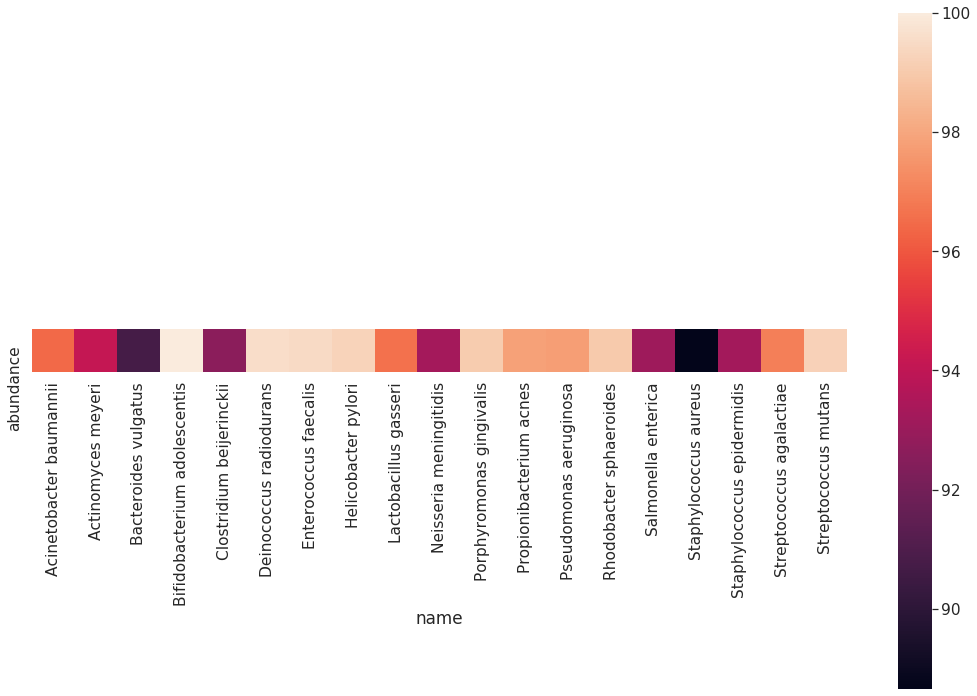

In [19]:
#plot the heatmap for organims to abundance
#dfData3.sort_values('abundance',ascending=False)
piv = pd.pivot_table(dfData3, values="abundance", columns=["name"], fill_value=0)
#piv.sort_index(axis=0,ascending=True, inplace=True)
#plot pivot table as heatmap using seaborn
sns.set(font_scale=1.4)
plt.figure(figsize=(15, 10))
ax = sns.heatmap(piv, square=True,xticklabels=1,annot_kws={"size": 16})
#plt.setp( ax.xaxis.get_minorticklabels(), rotation=180 )
plt.setp( ax.yaxis.get_majorticklabels(), rotation=90 )
plt.tight_layout()
#"Save the Report"
Myfig1=S_path+"/"+Sample+fig1
print(Myfig1)
plt.savefig(Myfig1)
plt.show()
plt.close()

In [20]:
dfData3.to_csv("MINDS_results.csv",index=False,encoding='utf-8')

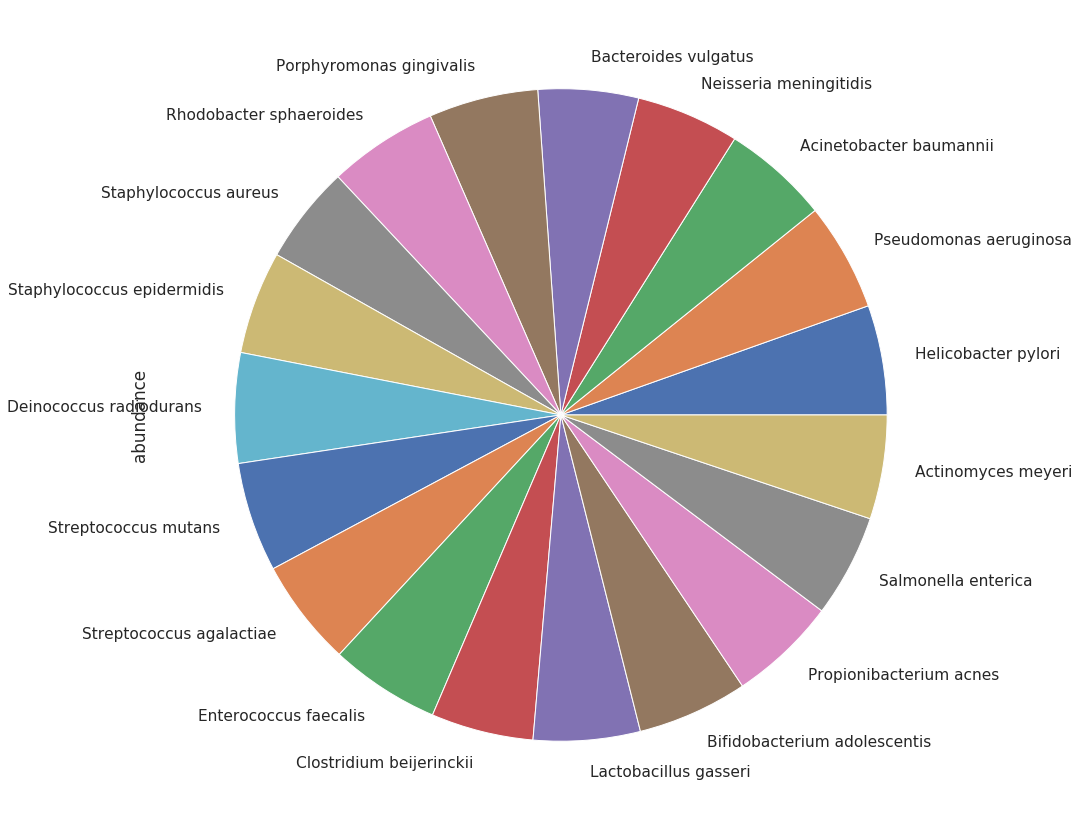

In [21]:
plot = dfData3.plot.pie(y='abundance', labels=dfData3["name"],figsize=(15, 15),legend=False)

plt.tight_layout()
#"Save the Report"
Myfig2=S_path+"/"+Sample+fig2
plt.savefig(Myfig2)
plt.show()

In [22]:
dfData3.sort_values('name',axis=0,ascending=False,inplace=True)
#plt.figure(figsize=(25,25))
#plt.plot(dfData3['abundance'],dfData3['name'])
#plt.title(Resultfile)
#plt.show()

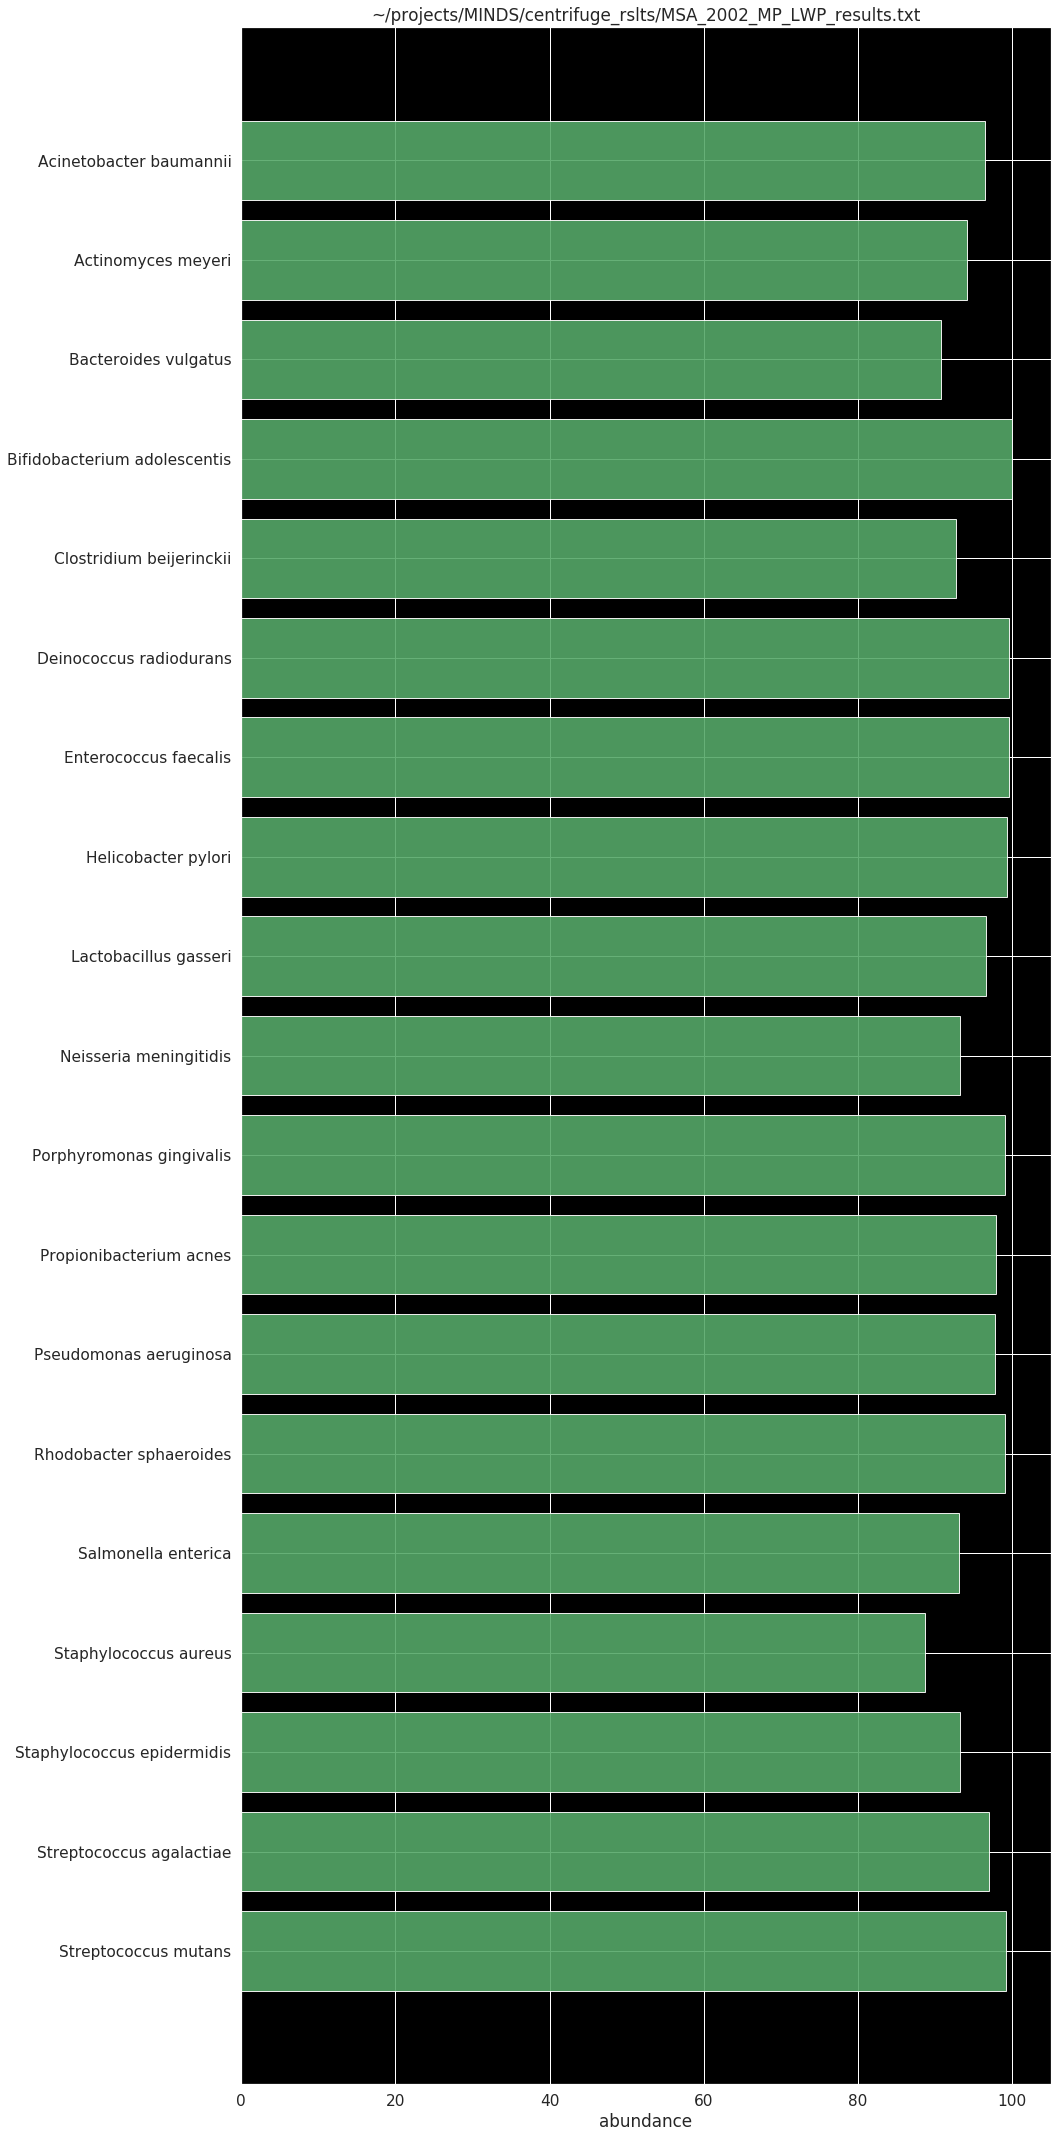

In [23]:
organism=dfData3['name']
y_pos=np.arange(len(organism))
howmuch=dfData3['abundance']
#print(dfData3['grades'])
plt.rcParams["axes.facecolor"]="black"
plt.rcParams["figure.facecolor"]="w"
#plt.rcParams.update({'font.size':32})
plt.figure(figsize=(15,30))
#Change the color of bar based on the grade"
plt.barh(y_pos,howmuch,alpha=0.9,color=np.where(dfData3['abundance']>60,'g','r'))
#plt.barh(y_pos,howmuch,alpha=0.9,color='black')
plt.yticks(y_pos,organism)
plt.xlabel('abundance')
plt.title(Resultfile)
plt.tight_layout()

#"Save the Report"
Myfig3=S_path+"/"+Sample+fig3
plt.savefig(Myfig3)
plt.show()

In [24]:
## ReportLab to generate the MINDS Summary Report
# 08/15/2019
from reportlab.platypus import SimpleDocTemplate,Image
from reportlab.platypus import Paragraph,Table,TableStyle,Spacer, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from reportlab.lib.units import inch, cm
from io import BytesIO
pdf_buffer = S_path+'/'+Sample+'_MINDS_Report.pdf'
my_doc = SimpleDocTemplate(pdf_buffer)
flowables = []

my_doc.build(flowables)

sample_style_sheet=getSampleStyleSheet()
paragraph_1 = Paragraph("MINDS Summary Report", sample_style_sheet['Heading1'])
paragraph_2 = Paragraph("Sample:"+samplename,sample_style_sheet['Heading2'])
paragraph_3=Paragraph("Total reads: "+str(Unique_reads)+"; Minimum number of reads: "+str(mini_reads).split('.')[0]+"; Sample Threshold cutoff(%): "+str(thrshold).split('.')[0],sample_style_sheet['BodyText'])

flowables.append(paragraph_1)
flowables.append(paragraph_2)
flowables.append(paragraph_3)

# Images are inserted here

histogram = Image(Myfig3)
histogram.drawHeight =  5.5*inch
histogram.drawWidth = 4.5*inch

piechart= Image(Myfig2)
piechart.drawHeight =  3.5*inch
piechart.drawWidth = 3.5*inch

heatmap= Image(Myfig1)
heatmap.drawHeight =  5.5*inch
heatmap.drawWidth = 4.5*inch

# Read the csv file and print it into the report

#PDF document layout
table_style = TableStyle([('ALIGN',(1,1),(-2,-2),'RIGHT'),
                       ('TEXTCOLOR',(1,1),(-2,-2),colors.red),
                       ('VALIGN',(0,0),(0,-1),'TOP'),
                       ('TEXTCOLOR',(0,0),(0,-1),colors.blue),
                       ('ALIGN',(0,-1),(-1,-1),'CENTER'),
                       ('VALIGN',(0,-1),(-1,-1),'MIDDLE'),
                       ('TEXTCOLOR',(0,-1),(-1,-1),colors.green),
                       ('INNERGRID', (0,0), (-1,-1), 0.25, colors.black),
                       ('BOX', (0,0), (-1,-1), 0.25, colors.black),
                       ])
styles = getSampleStyleSheet() 
styleNormal = styles['Normal']
styleHeading = styles['Heading1']
styleHeading2 = styles['Heading2'] 
styleHeading.alignment = 1 # centre text (TA_CENTRE) 

#Configure style and word wrap
s = getSampleStyleSheet()
s = s["BodyText"]
s.wordWrap = 'CJK'

# File that must be written to report
with open (ofile, 'r') as csvfile:
    reader = csv.reader(csvfile)
    lista = list(reader)

headers = lista[0]

conteo = 1

for numRecord in range(1,len(lista)):

    record1 = lista[numRecord]

    data = list()
    emptyRecords = list()
    records = list()
    header = list()

    countRecords = 0

    for line in record1:

        if line == '':
            emptyRecords.append(line)           
        else:
            records.append(line)
            header.append(headers[countRecords])

            data.append([str(headers[countRecords]), str(line)])

        countRecords = countRecords + 1
    #print(countRecords,numRecord)
    data2 = [[Paragraph(cell, s) for cell in row] for row in data]
    t = Table(data2)
    t.setStyle(table_style)
    flowables.append(t)
#-------------------------------------------------------

flowables.append(Spacer(inch, .25*inch))
flowables.append(heatmap)
flowables.append(piechart)
flowables.append(histogram)

my_doc.build(flowables)

In [25]:
print("Analysis completed & Report Printed")

Analysis completed & Report Printed


### NanoPlot analysis is done here

In [325]:
%timeit
statsRslts='~/projects/MINDS/logs/'
! NanoPlot -t 8 -o statsRslts --fastq /media/nuc-2/Data/CARA_centrifuge/VEE-fongle/VEE-RNA002_cDNA.fastq --plots 'kde'

In [322]:
print(fastq_file)

/media/nuc-2/Data/CARA_centrifuge/VEE-fongle/VEE-RNA002_cDNA.fastq
